<a href="https://colab.research.google.com/github/jyotidabass/Emotion-Recognition-in-Conversation/blob/main/Emotion_Recognition_in_Conversation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/SubhamIO/Emotion-Recognition-in-Conversation

fatal: destination path 'Emotion-Recognition-in-Conversation' already exists and is not an empty directory.


In [2]:
path="/content/Emotion-Recognition-in-Conversation/data/MELD"

In [3]:
import nltk
nltk.download('stopwords')

import pandas as pd
import seaborn as sns
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Activation, Embedding, BatchNormalization

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [5]:
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [6]:
train = pd.read_csv('/content/Emotion-Recognition-in-Conversation/data/MELD/train_sent_emo.csv')
cv = pd.read_csv('/content/Emotion-Recognition-in-Conversation/data/MELD/dev_sent_emo.csv')
test = pd.read_csv('/content/Emotion-Recognition-in-Conversation/data/MELD/test_sent_emo.csv')

In [7]:
train.shape, cv.shape , test.shape

((9989, 11), (1109, 11), (2610, 11))

In [8]:
train.columns

Index(['Sr No.', 'Utterance', 'Speaker', 'Emotion', 'Sentiment', 'Dialogue_ID',
       'Utterance_ID', 'Season', 'Episode', 'StartTime', 'EndTime'],
      dtype='object')

In [9]:
cv.columns

Index(['Sr No.', 'Utterance', 'Speaker', 'Emotion', 'Sentiment', 'Dialogue_ID',
       'Utterance_ID', 'Season', 'Episode', 'StartTime', 'EndTime'],
      dtype='object')

In [10]:
test.columns

Index(['Sr No.', 'Utterance', 'Speaker', 'Emotion', 'Sentiment', 'Dialogue_ID',
       'Utterance_ID', 'Season', 'Episode', 'StartTime', 'EndTime'],
      dtype='object')

In [11]:
train.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"


neutral     4710
joy         1743
surprise    1205
anger       1109
sadness      683
disgust      271
fear         268
Name: Emotion, dtype: int64


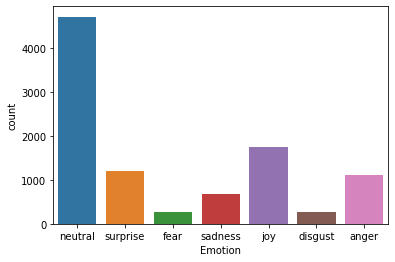

In [12]:

#Imbalanced Data
ax = sns.countplot(x=train['Emotion'], data=train)
print(train['Emotion'].value_counts())

neutral     470
joy         163
anger       153
surprise    150
sadness     111
fear         40
disgust      22
Name: Emotion, dtype: int64


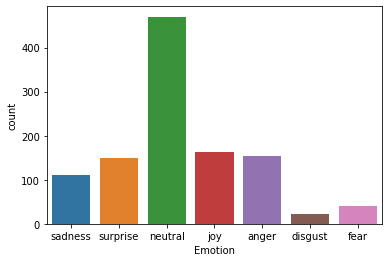

In [13]:
#Imbalanced Data
ax = sns.countplot(x=cv['Emotion'], data=cv)
print(cv['Emotion'].value_counts())

neutral     1256
joy          402
anger        345
surprise     281
sadness      208
disgust       68
fear          50
Name: Emotion, dtype: int64


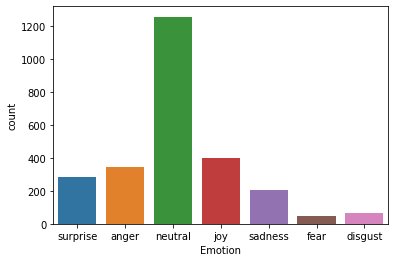

In [14]:
#Imbalanced Data
ax = sns.countplot(x=test['Emotion'], data=test)
print(test['Emotion'].value_counts())

In [15]:
train.info() #No nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9989 entries, 0 to 9988
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        9989 non-null   int64 
 1   Utterance     9989 non-null   object
 2   Speaker       9989 non-null   object
 3   Emotion       9989 non-null   object
 4   Sentiment     9989 non-null   object
 5   Dialogue_ID   9989 non-null   int64 
 6   Utterance_ID  9989 non-null   int64 
 7   Season        9989 non-null   int64 
 8   Episode       9989 non-null   int64 
 9   StartTime     9989 non-null   object
 10  EndTime       9989 non-null   object
dtypes: int64(5), object(6)
memory usage: 858.6+ KB


In [16]:
cv.info()  #No nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1109 entries, 0 to 1108
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        1109 non-null   int64 
 1   Utterance     1109 non-null   object
 2   Speaker       1109 non-null   object
 3   Emotion       1109 non-null   object
 4   Sentiment     1109 non-null   object
 5   Dialogue_ID   1109 non-null   int64 
 6   Utterance_ID  1109 non-null   int64 
 7   Season        1109 non-null   int64 
 8   Episode       1109 non-null   int64 
 9   StartTime     1109 non-null   object
 10  EndTime       1109 non-null   object
dtypes: int64(5), object(6)
memory usage: 95.4+ KB


In [17]:
test.info()  #No nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2610 entries, 0 to 2609
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        2610 non-null   int64 
 1   Utterance     2610 non-null   object
 2   Speaker       2610 non-null   object
 3   Emotion       2610 non-null   object
 4   Sentiment     2610 non-null   object
 5   Dialogue_ID   2610 non-null   int64 
 6   Utterance_ID  2610 non-null   int64 
 7   Season        2610 non-null   int64 
 8   Episode       2610 non-null   int64 
 9   StartTime     2610 non-null   object
 10  EndTime       2610 non-null   object
dtypes: int64(5), object(6)
memory usage: 224.4+ KB


In [18]:
X_train , y_train = train[['Utterance']] , train[['Emotion']]
X_cv , y_cv = cv[['Utterance']] , cv[['Emotion']]
X_test , y_test = test[['Utterance']] , test[['Emotion']]

In [19]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [20]:
mll_scorer = metrics.make_scorer(multiclass_logloss, greater_is_better=False, needs_proba=True)

In [21]:
lbl_enc = preprocessing.LabelEncoder()
y_train_enc = lbl_enc.fit_transform(y_train.Emotion.values)
y_cv_enc = lbl_enc.transform(y_cv.Emotion.values)
y_test_enc = lbl_enc.transform(y_test.Emotion.values)

In [22]:
y_train.Emotion.values[1:200]

array(['neutral', 'neutral', 'neutral', 'surprise', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'fear', 'neutral', 'surprise',
       'neutral', 'surprise', 'sadness', 'surprise', 'fear', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'joy', 'sadness',
       'surprise', 'neutral', 'disgust', 'sadness', 'neutral', 'neutral',
       'joy', 'neutral', 'joy', 'surprise', 'surprise', 'surprise',
       'neutral', 'neutral', 'neutral', 'surprise', 'sadness', 'neutral',
       'surprise', 'joy', 'surprise', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'joy', 'joy', 'joy', 'sadness', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'surprise',
       'joy', 'surprise', 'joy', 'neutral', 'neutral', 'anger', 'joy',
       'neutral', 'surprise', 'anger', 'anger', 'anger', 'neutral',
       'neutral', 'sadness', 'sadness', 'sadness', 'surprise', 'anger',
       'anger', 'anger', 'anger', 'neutral', 'anger', 'neutral',
     

In [23]:
y_train_enc[1:200]

array([4, 4, 4, 6, 4, 4, 4, 4, 4, 2, 4, 6, 4, 6, 5, 6, 2, 4, 4, 4, 4, 4,
       3, 5, 6, 4, 1, 5, 4, 4, 3, 4, 3, 6, 6, 6, 4, 4, 4, 6, 5, 4, 6, 3,
       6, 4, 4, 4, 4, 4, 3, 3, 3, 5, 4, 4, 4, 4, 4, 4, 6, 3, 6, 3, 4, 4,
       0, 3, 4, 6, 0, 0, 0, 4, 4, 5, 5, 5, 6, 0, 0, 0, 0, 4, 0, 4, 4, 4,
       4, 3, 4, 3, 4, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 4, 1, 0, 0, 0, 0, 0,
       0, 4, 4, 0, 4, 3, 4, 4, 3, 3, 3, 3, 4, 3, 1, 6, 1, 4, 2, 4, 6, 2,
       1, 0, 3, 4, 6, 4, 4, 4, 4, 6, 4, 4, 0, 4, 4, 5, 6, 5, 0, 5, 4, 5,
       4, 4, 4, 4, 4, 3, 0, 0, 0, 4, 0, 3, 3, 3, 3, 1, 6, 4, 4, 0, 3, 4,
       4, 2, 4, 2, 3, 3, 3, 3, 4, 4, 4, 3, 4, 3, 2, 4, 5, 6, 2, 4, 4, 4,
       3])

In [24]:
import re

### Dataset Preprocessing training set
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
train_corpus = []
for i in range(0, len(X_train)):
    review = re.sub('[^a-zA-Z]', ' ', X_train['Utterance'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    train_corpus.append(review)

In [25]:
import re

### Dataset Preprocessing cv set
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
cv_corpus = []
for i in range(0, len(X_cv)):
    review = re.sub('[^a-zA-Z]', ' ', X_cv['Utterance'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    cv_corpus.append(review)

In [26]:
import re

### Dataset Preprocessing test set
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
test_corpus = []
for i in range(0, len(X_test)):
    review = re.sub('[^a-zA-Z]', ' ', X_test['Utterance'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    test_corpus.append(review)
     

In [27]:
X_train['clean_utterance'] = train_corpus
X_train.drop('Utterance',axis=1,inplace=True)

<ipython-input-27-879f84db78d3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['clean_utterance'] = train_corpus
/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [28]:
X_cv['clean_utterance'] = cv_corpus
X_cv.drop('Utterance',axis=1,inplace=True)

<ipython-input-28-f71b4cedf913>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cv['clean_utterance'] = cv_corpus


In [29]:
X_test['clean_utterance'] = test_corpus
X_test.drop('Utterance',axis=1,inplace=True)

<ipython-input-29-edd2d281ca5b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['clean_utterance'] = test_corpus


In [30]:
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(X_train['clean_utterance']) + list(X_cv['clean_utterance']) + list(X_test['clean_utterance']))
X_train_tfv =  tfv.transform(X_train['clean_utterance']) 
X_valid_tfv = tfv.transform(X_cv['clean_utterance'])
X_test_tfv = tfv.transform(X_test['clean_utterance'])

/usr/local/lib/python3.9/dist-packages/sklearn/utils/_param_validation.py:541: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


In [31]:
X_train_tfv.shape,X_valid_tfv.shape,X_test_tfv.shape

((9989, 3179), (1109, 3179), (2610, 3179))

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score


alpha = [10 ** x for x in range(-6, 3)]


# initialize Our first RandomForestRegressor model...
regr2 = LogisticRegression()

# declare parameters for hyperparameter tuning
parameters = {'C':alpha} 

# Perform cross validation 
clf = GridSearchCV(regr2,
                    param_grid = parameters,
                    scoring=mll_scorer,
                    n_jobs = -1,
                    verbose = 10, refit=True, cv=2)
result = clf.fit(X_train_tfv, y_train_enc)

# Summarize results
print("Best: %f using %s" % (result.best_score_, result.best_params_))
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f 1(%f) with: %r" % (mean, stdev, param))

Fitting 2 folds for each of 9 candidates, totalling 18 fits
Best: -1.417605 using {'C': 1}
-1.536665 1(0.000177) with: {'C': 1e-06}
-1.536648 1(0.000177) with: {'C': 1e-05}
-1.536480 1(0.000177) with: {'C': 0.0001}
-1.534834 1(0.000178) with: {'C': 0.001}
-1.520896 1(0.000221) with: {'C': 0.01}
-1.463340 1(0.000332) with: {'C': 0.1}
-1.417605 1(0.004722) with: {'C': 1}
-1.622374 1(0.001400) with: {'C': 10}
-2.300198 1(0.032855) with: {'C': 100}


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [33]:
lr = LogisticRegression(C = 1)
lr.fit(X_train_tfv, y_train_enc)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1)

In [34]:
predictions = lr.predict_proba(X_train_tfv)
print ("logloss: %0.3f " % multiclass_logloss(y_train_enc, predictions))

logloss: 1.129 


In [35]:
predictions = lr.predict_proba(X_valid_tfv)
print ("logloss: %0.3f " % multiclass_logloss(y_cv_enc, predictions))

logloss: 1.477 


In [36]:
predictions = lr.predict_proba(X_test_tfv)
print ("logloss: %0.3f " % multiclass_logloss(y_test_enc, predictions))

logloss: 1.372 


In [37]:
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(X_train['clean_utterance']) + list(X_cv['clean_utterance']) + list(X_test['clean_utterance']))
X_train_ctv =  ctv.transform(X_train['clean_utterance']) 
X_valid_ctv = ctv.transform(X_cv['clean_utterance'])
X_test_ctv = ctv.transform(X_test['clean_utterance'])

In [38]:
X_train_ctv.shape,X_valid_ctv.shape,X_test_ctv.shape

((9989, 51082), (1109, 51082), (2610, 51082))

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score


alpha = [10 ** x for x in range(-6, 3)]


# initialize Our first RandomForestRegressor model...
regr2 = LogisticRegression()

# declare parameters for hyperparameter tuning
parameters = {'C':alpha} 

# Perform cross validation 
clf = GridSearchCV(regr2,
                    param_grid = parameters,
                    scoring=mll_scorer,
                    n_jobs = -1,
                    verbose = 10, refit=True, cv=2)
result = clf.fit(X_train_ctv, y_train_enc)

# Summarize results
print("Best: %f using %s" % (result.best_score_, result.best_params_))
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f 1(%f) with: %r" % (mean, stdev, param))

Fitting 2 folds for each of 9 candidates, totalling 18 fits
Best: -1.427496 using {'C': 0.1}
-1.536658 1(0.000176) with: {'C': 1e-06}
-1.536569 1(0.000177) with: {'C': 1e-05}
-1.535706 1(0.000178) with: {'C': 0.0001}
-1.528054 1(0.000209) with: {'C': 0.001}
-1.489068 1(0.000305) with: {'C': 0.01}
-1.427496 1(0.001608) with: {'C': 0.1}
-1.460494 1(0.008207) with: {'C': 1}
-1.784024 1(0.024597) with: {'C': 10}
-2.629066 1(0.109235) with: {'C': 100}


In [40]:
lr = LogisticRegression(C = 0.1)
lr.fit(X_train_ctv, y_train_enc)

LogisticRegression(C=0.1)

In [41]:

predictions = lr.predict_proba(X_train_ctv)
print ("logloss: %0.3f " % multiclass_logloss(y_train_enc, predictions))

logloss: 1.115 


In [42]:
predictions = lr.predict_proba(X_valid_ctv)
print ("logloss: %0.3f " % multiclass_logloss(y_cv_enc, predictions))

logloss: 1.501 


In [43]:
predictions = lr.predict_proba(X_valid_ctv)
print ("logloss: %0.3f " % multiclass_logloss(y_cv_enc, predictions))

logloss: 1.501 


In [44]:
predictions = lr.predict_proba(X_test_ctv)
print ("logloss: %0.3f " % multiclass_logloss(y_test_enc, predictions))

logloss: 1.394 
